In [1]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, auc, r2_score
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn import tree


In [2]:
df = pd.read_csv('CLEAN- PCOS SURVEY SPREADSHEET.csv')

# Basic checks
print(df.head())
print(df.isnull().sum())  # No Null values
print(df.info())
print(df.nunique())

# Check unique blood groups
print(df['Can you tell us your blood group ?'].unique())


   Age (in Years)  Weight (in Kg)  Height (in Cm / Feet)  \
0              21            47.0                  168.0   
1              21            45.0                  156.0   
2              17            37.0                  162.0   
3              28            54.0                  160.0   
4              45            40.0                  150.0   

   Can you tell us your blood group ?  \
0                                  13   
1                                  11   
2                                  15   
3                                  15   
4                                  13   

   After how many months do you get your periods?\n(select 1- if every month/regular)  \
0                                                  1                                    
1                                                  1                                    
2                                                  1                                    
3                                   

In [3]:
df = df.rename(columns={
    "Age (in Years)": "Age",  
    "Weight (in Kg)": "Weight",  
    "Height (in Cm / Feet)": "Height",  
    "Can you tell us your blood group ?": "Blood Group",  
    "After how many months do you get your periods?\n(select 1- if every month/regular)": "Menstrual Cycle Interval",  
    "Have you gained weight recently?": "Recent Weight Gain",  
    "Are you noticing skin darkening recently?": "Skin Darkening",  
    "Do have hair loss/hair thinning/baldness ?": "Hair Loss",  
    "Do you have pimples/acne on your face/jawline ?": "Acne",  
    "Do you eat fast food regularly ?": "Regular Fast Food Consumption",  
    "Do you exercise on a regular basis ?": "Regular Exercise",  
    "Have you been diagnosed with PCOS/PCOD?": "PCOS Diagnosis",  
    "Do you experience mood swings ?": "Mood Swings",  
    "Are your periods regular ?": "Regular Periods",  
    "Do you have excessive body/facial hair growth ?": "Excessive Body/Facial Hair",  
    "How long does your period last ? (in Days)\nexample- 1,2,3,4.....": "Menstrual Duration (Days)"  
})


In [4]:
print(df['PCOS Diagnosis'].value_counts())
print(df['Regular Periods'].value_counts())


PCOS Diagnosis
0    363
1    102
Name: count, dtype: int64
Regular Periods
1    365
0    100
Name: count, dtype: int64


In [5]:
X = df.drop(columns=['PCOS Diagnosis'])
Y = df['PCOS Diagnosis']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)


In [6]:
def calculate_metrics(model, X_test, Y_test):
    Yhat = model.predict(X_test)
    Y_proba = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(Y_test, Y_proba, pos_label=1)

    metrics = pd.DataFrame(index=['Model'], columns=['Acc', 'Prec', 'Rec', 'F1', 'AUC', 'AUPR'])
    metrics.at['Model', 'Acc'] = accuracy_score(Y_test, Yhat)
    metrics.at['Model', 'Prec'] = precision_score(Y_test, Yhat, pos_label=1)
    metrics.at['Model', 'Rec'] = recall_score(Y_test, Yhat, pos_label=1)
    metrics.at['Model', 'F1'] = f1_score(Y_test, Yhat, pos_label=1)
    metrics.at['Model', 'AUC'] = roc_auc_score(Y_test, Y_proba)
    metrics.at['Model', 'AUPR'] = auc(recall, precision)

    return metrics


In [7]:
rf = RandomForestClassifier().fit(X_train, Y_train)

# Save and Load
with open("pcos_randomforest1.pkl", "wb") as file:
    pickle.dump(rf, file)

with open("pcos_randomforest1.pkl", "rb") as file:
    model = pickle.load(file)

print(calculate_metrics(model, X_test, Y_test))


            Acc Prec       Rec        F1       AUC      AUPR
Model  0.854701  1.0  0.392857  0.564103  0.814807  0.704742


            Acc      Prec       Rec    F1       AUC      AUPR
Model  0.846154  0.916667  0.392857  0.55  0.800762  0.771384


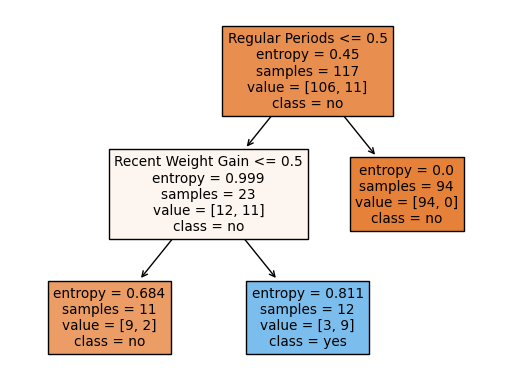

In [8]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10)
dt.fit(X_test, model.predict(X_test))

with open("pcos_decisiontree1.pkl", "wb") as file:
    pickle.dump(dt, file)

with open("pcos_decisiontree1.pkl", "rb") as file:
    model = pickle.load(file)

tree.plot_tree(model, feature_names=X.columns, class_names=['no', 'yes'], filled=True)
print(calculate_metrics(model, X_test, Y_test))


In [9]:
Yhat = cross_val_predict(rf, X, Y, cv=10)

dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10).fit(X, Yhat)
Y_hat = dt.predict(X_test)

with open("pcos_stacking_rf_dt.pkl", "wb") as file:
    pickle.dump(dt, file)

with open("pcos_stacking_rf_dt.pkl", "rb") as file:
    model = pickle.load(file)

print(calculate_metrics(model, X_test, Y_test))


            Acc      Prec       Rec        F1       AUC      AUPR
Model  0.863248  0.833333  0.535714  0.652174  0.810995  0.728274


In [10]:
svm = SVC(kernel='linear', probability=True).fit(X_train, Y_train)

with open("pcos_svm1.pkl", "wb") as file:
    pickle.dump(svm, file)

with open("pcos_svm1.pkl", "rb") as file:
    model = pickle.load(file)

print(calculate_metrics(model, X_test, Y_test))


            Acc      Prec       Rec        F1      AUC      AUPR
Model  0.846154  0.857143  0.428571  0.571429  0.82183  0.693768


In [11]:
Yhat = cross_val_predict(svm, X, Y, cv=10)
lr = LogisticRegression(max_iter=1000).fit(X, Yhat)

with open("pcos_stacking_svm_lr.pkl", "wb") as file:
    pickle.dump(lr, file)

with open("pcos_stacking_svm_lr.pkl", "rb") as file:
    model = pickle.load(file)

print(calculate_metrics(model, X_test, Y_test))

coef = pd.DataFrame(model.coef_)
coef.columns = X.columns
print(coef)


            Acc      Prec       Rec        F1      AUC      AUPR
Model  0.871795  0.782609  0.642857  0.705882  0.79695  0.715184
        Age    Weight    Height  Blood Group  Menstrual Cycle Interval  \
0 -0.010541 -0.000068  0.001229     0.037731                   1.48086   

   Recent Weight Gain  Excessive Body/Facial Hair  Skin Darkening  Hair Loss  \
0            0.325109                    0.212453        0.098446  -0.123364   

       Acne  Regular Fast Food Consumption  Regular Exercise  Mood Swings  \
0  0.126647                      -0.189706         -0.030085     0.161597   

   Regular Periods  Menstrual Duration (Days)  
0        -5.906289                   -0.06706  


In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, Y_train)

with open("pcos_rf2.pkl", "wb") as file:
    pickle.dump(rf, file)

with open("pcos_rf2.pkl", "rb") as file:
    model = pickle.load(file)

print(calculate_metrics(rf, X_test, Y_test))


            Acc Prec       Rec        F1       AUC      AUPR
Model  0.854701  1.0  0.392857  0.564103  0.813403  0.709685


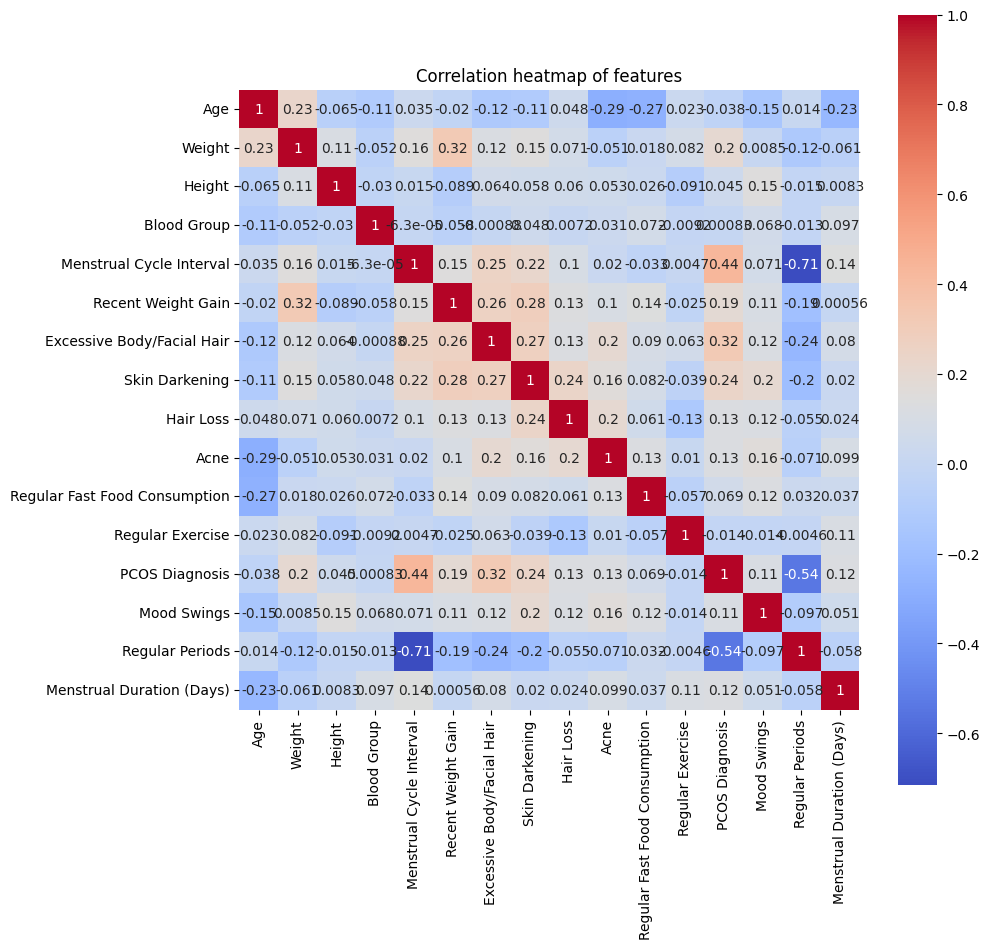

In [13]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation heatmap of features")
plt.show()


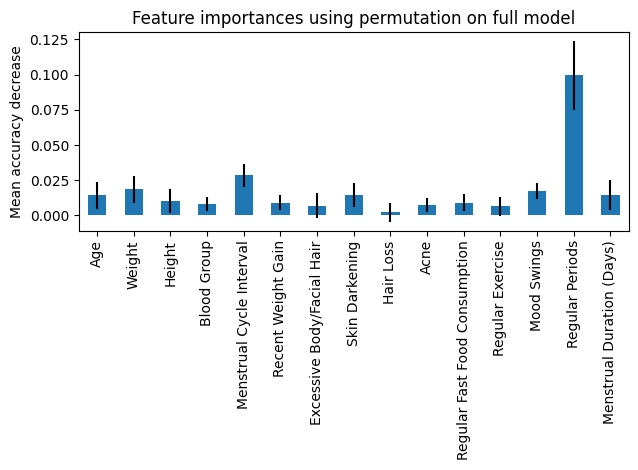

In [14]:
result = permutation_importance(rf, X_test, Y_test, n_repeats=30, random_state=0)
forest_importances = pd.Series(result.importances_mean, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


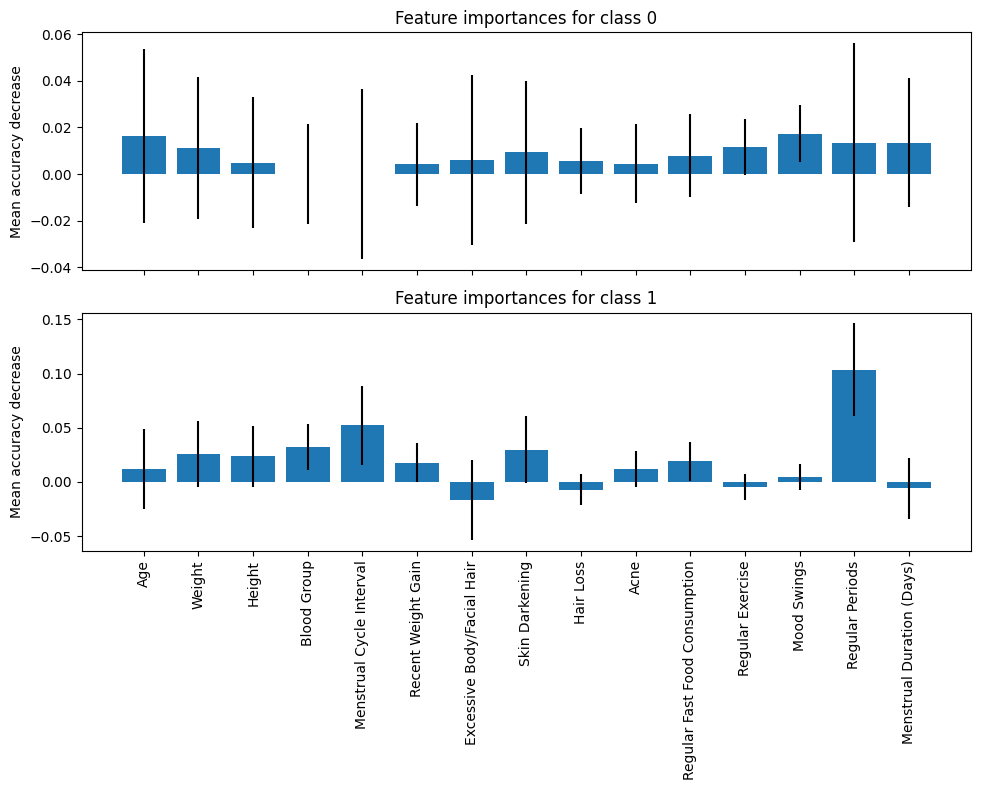

In [15]:
class_0_importances = {}
class_1_importances = {}

for class_label in [0, 1]:
    X_test_class = X_test[Y_test == class_label]
    Y_test_class = Y_test[Y_test == class_label]

    result = permutation_importance(rf, X_test_class, Y_test_class, n_repeats=30, random_state=0)

    if class_label == 0:
        class_0_importances = result.importances_mean
    else:
        class_1_importances = result.importances_mean

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
axs[0].bar(X.columns, class_0_importances, yerr=result.importances_std)
axs[0].set_title("Feature importances for class 0")
axs[0].set_ylabel("Mean accuracy decrease")

axs[1].bar(X.columns, class_1_importances, yerr=result.importances_std)
axs[1].set_title("Feature importances for class 1")
axs[1].set_ylabel("Mean accuracy decrease")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


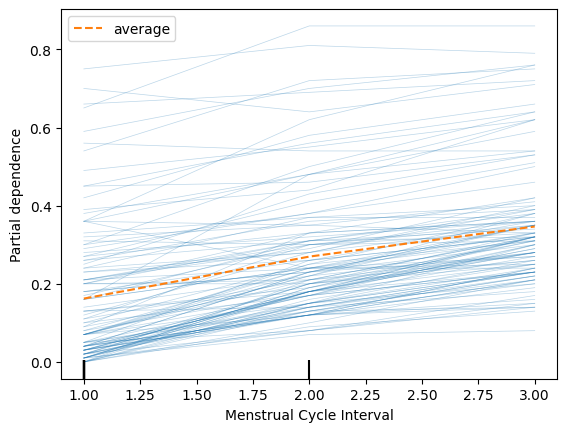

In [16]:
disp1 = PartialDependenceDisplay.from_estimator(rf, X_test, [4], kind='both', target=1)


In [17]:
# Load all models
with open("pcos_randomforest1.pkl", "rb") as file: rf1 = pickle.load(file)
with open("pcos_decisiontree1.pkl", "rb") as file: dt1 = pickle.load(file)
with open("pcos_stacking_rf_dt.pkl", "rb") as file: stacking1 = pickle.load(file)
with open("pcos_svm1.pkl", "rb") as file: svm1 = pickle.load(file)
with open("pcos_stacking_svm_lr.pkl", "rb") as file: stacking2 = pickle.load(file)
with open("pcos_rf2.pkl", "rb") as file: rf2 = pickle.load(file)


In [20]:
# Dictionary of models
models = {
    "Random Forest v1": rf1,
    "Decision Tree": dt1,
    "Stacking RF + DT": stacking1,
    "SVM": svm1,
    "Stacking SVM + LR": stacking2,
    "Random Forest v2": rf2
}

# Evaluate each model and collect results
results_list = []

for name, model in models.items():
    metrics_df = calculate_metrics(model, X_test, Y_test)
    # Flatten the single-row DataFrame to a dict and add model name
    metrics_dict = metrics_df.iloc[0].to_dict()
    metrics_dict["Model"] = name
    results_list.append(metrics_dict)

# Create DataFrame from the list of metric dicts
results_df = pd.DataFrame(results_list)

# Set 'Model' as the index
results_df = results_df.set_index("Model")

# Round for better readability and sort by F1 score
results_df = results_df.round(4).sort_values(by="F1", ascending=False)

# Display the results
print(results_df)


                      Acc    Prec     Rec      F1     AUC    AUPR
Model                                                            
Stacking SVM + LR  0.8718  0.7826  0.6429  0.7059  0.7970  0.7152
Stacking RF + DT   0.8632  0.8333  0.5357  0.6522  0.8110  0.7283
SVM                0.8462  0.8571  0.4286  0.5714  0.8218  0.6938
Random Forest v1   0.8547  1.0000  0.3929  0.5641  0.8148  0.7047
Random Forest v2   0.8547  1.0000  0.3929  0.5641  0.8134  0.7097
Decision Tree      0.8462  0.9167  0.3929  0.5500  0.8008  0.7714


In [21]:
results_df.style.background_gradient(cmap='Blues').format("{:.2%}")


,Acc,Prec,Rec,F1,AUC,AUPR
Model,,,,,,
Stacking SVM + LR,87.18%,78.26%,64.29%,70.59%,79.70%,71.52%
Stacking RF + DT,86.32%,83.33%,53.57%,65.22%,81.10%,72.83%
SVM,84.62%,85.71%,42.86%,57.14%,82.18%,69.38%
Random Forest v1,85.47%,100.00%,39.29%,56.41%,81.48%,70.47%
Random Forest v2,85.47%,100.00%,39.29%,56.41%,81.34%,70.97%
Decision Tree,84.62%,91.67%,39.29%,55.00%,80.08%,77.14%


C:\Users\sneha\AppData\Local\Temp\ipykernel_8224\379950003.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y='F1', data=results_df, palette='viridis')


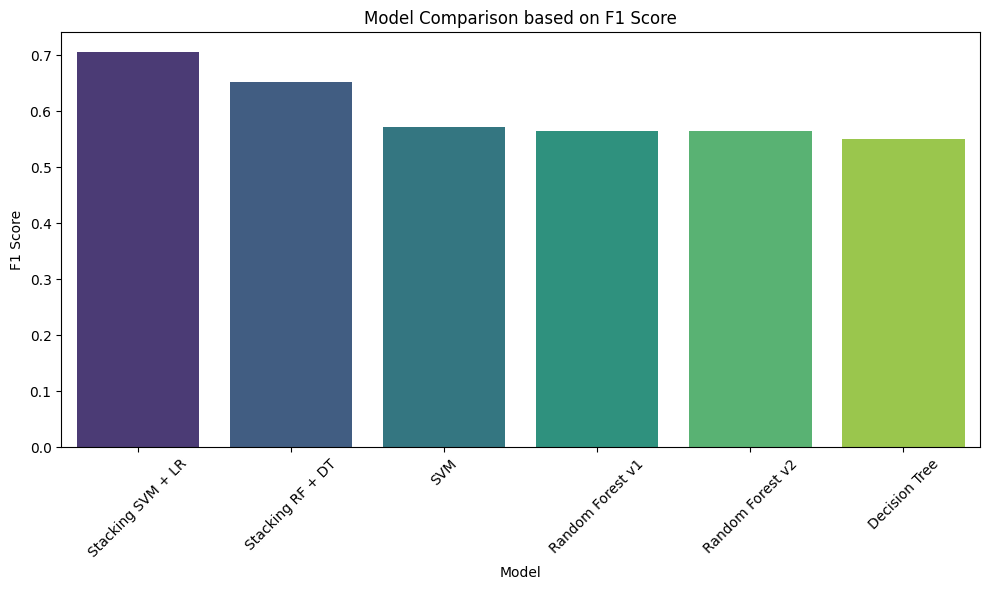

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=results_df.index, y='F1', data=results_df, palette='viridis')
plt.ylabel("F1 Score")
plt.title("Model Comparison based on F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 Key Features for PCOS Prediction:
Strong predictors:

Regular Periods (absence is a major signal)

Menstrual Cycle Interval

Moderate contributors:

Skin Darkening, Weight Gain, Excessive Body/Facial Hair

Low relevance:

Blood Group, Acne, Hair Loss, Exercise

Best Model:
Stacking SVM + LR gives the highest F1 score 